# Calibration of the Chaboche mecanical model with least squares

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = g(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\sigma$ is the stress (Pa),
- $\epsilon$ is the strain,
- $R$, $C$, $\gamma$ are the parameters.

Caution: 
* The strain $\epsilon$ is not the random error of the least squares model. 
* The stress $\sigma$ is not the standard deviation of the random noise of the output observations.


## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\boldsymbol{\theta} = (R,C,\gamma).
$$

The true values of the parameters are:

- $R = 750\times 10^6$ (Pa),
- $C = 2750\times 10^6$ (Pa),
- $\gamma = 10$.


## Observations

We assume the observed constraint has a Gaussian distribution:

$$
\epsilon_\sigma \sim \mathcal{N} \left(0, \sigma_\epsilon^2\right)
$$

where $\sigma_\epsilon > 0$ is unknown.
We make the hypothesis that the observation errors are independent.
We are given $n = 10$ observations.
We consider a Monte-Carlo sample with size $n$:

$$
\sigma^{(i)} = g\left(\epsilon^{(i)},R,C,\gamma\right) + \left(\epsilon_\sigma\right)^{(i)}, 
$$

for $i \in \{1,..., n\}$.
The observations are the pairs $\left\{\left(\epsilon^{(i)},\sigma^{(i)}\right)\right\}_{1 \leq i \leq n}$, i.e. each observation is a couple made of the strain and the corresponding stress.



## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002). _"Mechanics of solid materials"_. Cambridge University Press.

## Mise à l'échelle
Une difficulté pratique de ce modèle est que l'ordre de grandeur d'une contrainte est en méga Pascal c'est-à-dire $10^6$ Pa. Ces valeurs numériques sont bien plus grandes que la déformation dont l'ordre de grandeur est égal à $10^{-2}$. Cela complique plusieurs étapes dans l'analyse :
- dans le paramétrage du modèle :
	- dans Persalys, la mise en œuvre utilise des nombres avec un grand nombre de zéros,
	- le choix du pas de différentiation est moins facile (voir la suite pour plus de détails sur ce sujet),
- dans le traitement des résultats, les graphiques et les valeurs numériques sont peu commodes.

Dans le but de faciliter le travail, nous considérons par la suite des contraintes en MPa. On rappelle que 1 MPa = $10^6$ Pa, et que "Pa" est l'abbréviation de Pascal. 


## Load the observations

In [1]:
import numpy as np
import openturns as ot
from openturns.usecases import chaboche_model
import openturns.viewer as otv
import pylab as pl
import tabulate

Load the Chaboche model

In [2]:
cm = chaboche_model.ChabocheModel()

See the dataset.

In [3]:
cm.data

,Strain,Stress (Pa)
0,0,7.56e+08
1,0.0077,7.57e+08
2,0.0155,7.85e+08
3,0.0233,8.19e+08
4,0.0311,8.01e+08
5,0.0388,8.42e+08
6,0.0466,8.49e+08
7,0.0544,8.79e+08
8,0.0622,8.85e+08
9,0.07,8.96e+08


Load the observed stress data.

In [4]:
observedStress = cm.data[:, 1]
observedStress /= 1.0e6
observedStress.setDescription(["Stress (MPa)"])
observedStress

,Stress (MPa)
0,756
1,757
2,785
3,819
4,801
5,842
6,849
7,879
8,885
9,896


Load the sample of observed strains. 

In [5]:
observedStrain = cm.data[:, 0]
observedStrain

,Strain
0,0
1,0.0077
2,0.0155
3,0.0233
4,0.0311
5,0.0388
6,0.0466
7,0.0544
8,0.0622
9,0.07


See the data.

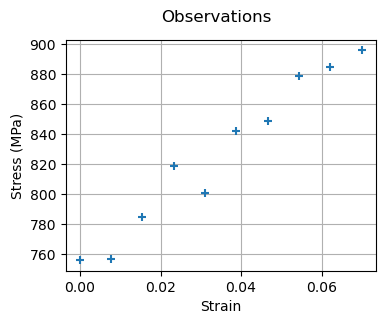

In [6]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress)
graph.add(cloud)
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Notice that the output stress depends almost linearily on the strain. We will see later that the actual model has a small but significant nonlinearity. The vertical deviation of the points from this curve depends on the observation noise.  

## Define the model

Create the Python function.

In [7]:
def modelChaboche(X):
    strain, R, C, gamma = X
    R *= 1.0e6  # Convert to Pa
    C *= 1.0e6  # Convert to Pa
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    stress /= 1.0e6  # Convert into Mpa
    return [stress]


g = ot.PythonFunction(4, 1, modelChaboche)
g.setInputDescription(["Strain", "R", "C", "Gamma"])
g.setOutputDescription(["Stress"])
g

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[]

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*. In this example, we use deterministic methods so that this is just the initial point of the least squares method. 

In [8]:
R_True = 750.0  # MPa
C_True = 2750.0  # MPa
gamma_True = 10.0

In [9]:
R = 700.0
C = 2500.0
Gamma = 8.0
thetaPrior = ot.Point([R, C, Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

The `chabocheParametric` function has:
* one input, the strain $\epsilon$,
* one output, the stress $\sigma$.

We want to calibrate this function i.e. we want to search for the values of the parameters R, C, Gamma that reduce the discrepancy between output observations and predictions. 

In [10]:
calibratedIndices = [1, 2, 3]
chabocheParametric = ot.ParametricFunction(g, calibratedIndices, thetaPrior)
chabocheParametric

class=FunctionImplementation name=Unnamed description=[Strain,Stress] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[1,2,3] parameters=class=PointWithDescription name=Unnamed dimension=3 description=[R,C,Gamma] values=[700,2500,8] input positions=[0] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[1,2,3] parameters=class=PointWithDescription name=Unnamed dimension=3 description=[R,C,Gamma] values=[700,2500,8] input positions=[0] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[1,2,3] parameters=class=PointWithDescription name=Unnamed dimension=3 description=[R,C,Gamma] values=[700,2500,8] input positions=[0]

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point. We use the Singular Value Decomposition (SVD) to solve the linear least squares problem. 

In [11]:
algo = ot.LinearLeastSquaresCalibration(
    chabocheParametric, observedStrain, observedStress, thetaPrior, "SVD"
)

The `run` method computes the solution of the problem.

In [12]:
algo.run()
calibrationResult_LLS = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$. In the linear least squares setting, this is the solution $\theta^\star$ of the linear least squares problem. 

In [13]:
thetaMAP_LLS = calibrationResult_LLS.getParameterMAP()
thetaMAP_LLS

class=Point name=Unnamed dimension=3 values=[750.188,2283.4,1.48027]

We can compute a 95% confidence interval of the parameter $\widehat{\boldsymbol{\theta}}$. This confidence interval is based on the assumption that the observation errors are Gaussian (otherwise the confidence interval is wrong). We will check this hypothesis later in the script.

Note. See https://github.com/openturns/openturns/issues/1106. computeBilateralConfidenceInterval sometimes fails.

In [14]:
thetaPosterior_LLS = calibrationResult_LLS.getParameterPosterior()
confidenceLevel = 0.95
ot.ResourceMap.SetAsUnsignedInteger("Normal-SmallDimension", 1)  # To make it fast
confidenceIntervalTheta_LLS = (
    thetaPosterior_LLS.computeBilateralConfidenceIntervalWithMarginalProbability(
        confidenceLevel
    )[0]
)
print(f"{100 * confidenceLevel:.0f}% C.I. for theta with LLS :")
print(confidenceIntervalTheta_LLS)

95% C.I. for theta with LLS :
[729.386, 770.989]
[668.109, 3898.69]
[-17.9134, 20.8739]


WRN - Warning, in Normal::computeProbability(), the dimension is very high. We will use a Monte Carlo method for the computation with a relative precision of 0.1% at 99% confidence level and a maximum of 100000000 realizations. Expect a long running time and a poor accuracy for low values of the CDF...


We can see that R, C parameters have a relatively small confidence interval, but Gamma has a very large confidence interval. The conclusion is that Gamma is not identifiable in this problem: its variability has no influence on the variability of the output. 

In order to understand the results more deeply, we draw several graphics. 

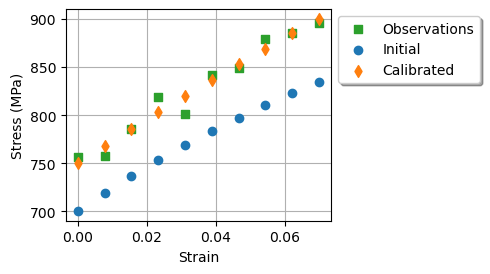

In [15]:
graph = calibrationResult_LLS.drawObservationsVsInputs().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

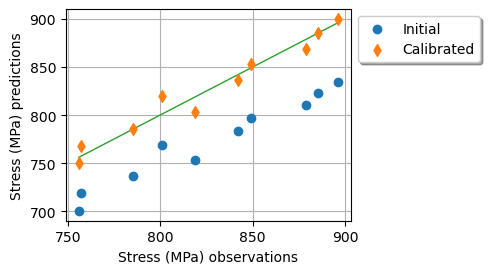

In [16]:
graph = calibrationResult_LLS.drawObservationsVsPredictions().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [17]:
observationError = calibrationResult_LLS.getObservationsError()
print(observationError)

Normal(mu = 0, sigma = 11.5394)


We see that the estimated standard deviation of the observation noise is $11.04$ (MPa) is is a relatively accurate estimate of the true value. 

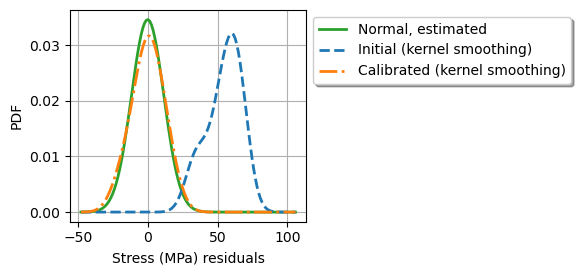

In [18]:
graph = calibrationResult_LLS.drawResiduals().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (6.0, 3.0)})

The analysis of the residuals (the blue curve) shows that the distribution is centered on zero and symmetric. 
Moreover, the distribution of the residuals is close to being Gaussian. 
This indicates that the calibration performed well. The confidence intervals that we computed for $\theta^\star$ are therefore valid and can be trusted. 

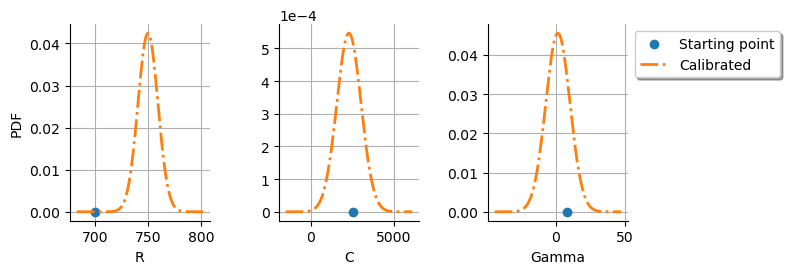

In [19]:
graph = calibrationResult_LLS.drawParameterDistributions()
otv.View(
    graph,
    figure_kw={"figsize": (8.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = pl.subplots_adjust(wspace=0.5)

We see that R and C can be estimated with relatively good accuracy. The Gamma parameter, however, cannot be identified. 

## Validation of the linear model

We check that the model can be linearized near the MAP. To see this, we set the parameters to the MAP and compute the predictions from the model.

See : CalibrationResult.drawObservationsVsInputs() can be misleading, https://github.com/openturns/openturns/issues/2280.

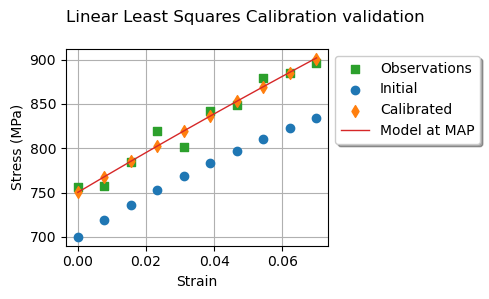

In [20]:
# From the model
chabocheParametric.setParameter(thetaMAP_LLS)
predictionsFromModel = chabocheParametric(observedStrain)

# Plot output depending on input.
graph = calibrationResult_LLS.drawObservationsVsInputs().getGraph(0, 0)
# From model at MAP
curve = ot.Curve(observedStrain, predictionsFromModel)
curve.setLegend("Model at MAP")
graph.add(curve)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
graph.setTitle("Linear Least Squares Calibration validation")
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

## Calibration with nonlinear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [21]:
algo = ot.NonLinearLeastSquaresCalibration(
    chabocheParametric, observedStrain, observedStress, thetaPrior
)

The `run` method computes the solution of the problem.

In [22]:
algo.run()
calibrationResult_NLLS = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [23]:
thetaMAP_NLLS = calibrationResult_NLLS.getParameterMAP()
thetaMAP_NLLS

class=Point name=Unnamed dimension=3 values=[749.825,2343.52,2.51939]

We can compute a 95% confidence interval of the parameter $\widehat{\boldsymbol{\theta}}$. 

In [24]:
thetaPosterior_NLLS = calibrationResult_NLLS.getParameterPosterior()
confidenceLevel = 0.95
confidenceIntervalTheta_NLLS = (
    thetaPosterior_NLLS.computeBilateralConfidenceIntervalWithMarginalProbability(
        confidenceLevel
    )[0]
)
print(f"{100 * confidenceLevel:.0f}% C.I. for theta with NLLS:")
print(confidenceIntervalTheta_NLLS)

95% C.I. for theta with NLLS:
[561.623, 788.075]
[666.314, 12472.8]
[-32.381, 32.2551]


We can see that R, C parameters have a relatively small confidence interval, but Gamma has a relatively large confidence interval. The conclusion is that Gamma cannot be identified with good accuracy. 

Notice however that the confidence interval for Gamma is larger than with the previous linear model. This shows that the model has some nonlinearity that must be taken into account. 

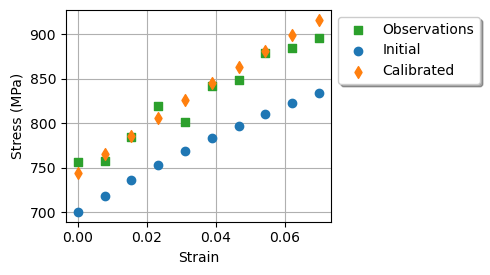

In [25]:
graph = calibrationResult_NLLS.drawObservationsVsInputs().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

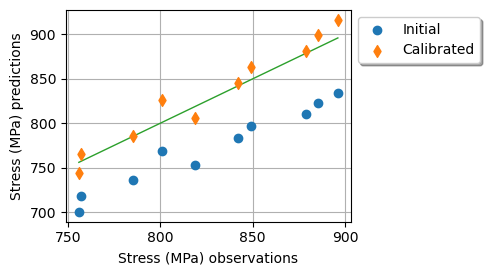

In [26]:
graph = calibrationResult_NLLS.drawObservationsVsPredictions().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [27]:
observationError = calibrationResult_NLLS.getObservationsError()
print(observationError)

Normal(mu = -5.10548e-05, sigma = 10.1976)


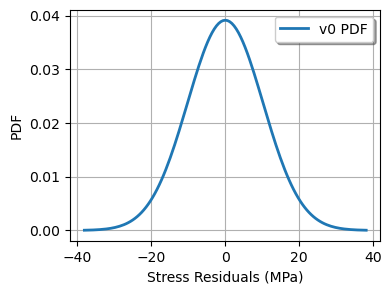

In [28]:
graph = observationError.drawPDF()
graph.setXTitle("Stress Residuals (MPa)")
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

The distribution of the observation error is Gaussian, with a standard deviation estimate equal to $10.1$ (MPa).

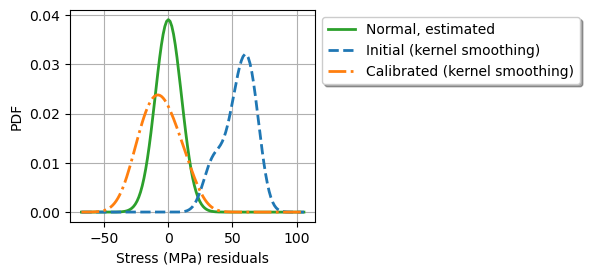

In [29]:
graph = calibrationResult_NLLS.drawResiduals().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (6.0, 3.0)})

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being Gaussian. This indicates that the observation error might be Gaussian.

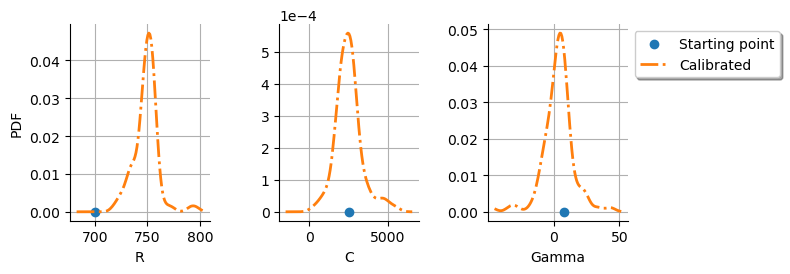

In [30]:
graph = calibrationResult_NLLS.drawParameterDistributions()
otv.View(
    graph,
    figure_kw={"figsize": (8.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = pl.subplots_adjust(wspace=0.5)

## Summary

We want to compare the results of linear least squares and non linear least squares.

In [31]:
# Get the bounds of the confidence intervals.
thetaLower_LLS = confidenceIntervalTheta_LLS.getLowerBound()
thetaUpper_LLS = confidenceIntervalTheta_LLS.getUpperBound()
thetaLower_NLLS = confidenceIntervalTheta_NLLS.getLowerBound()
thetaUpper_NLLS = confidenceIntervalTheta_NLLS.getUpperBound()

data = [
    ["Vrai", R_True, C_True, gamma_True, "", "", ""],
    ["Initial", thetaPrior[0], thetaPrior[1], thetaPrior[2], "", "", ""],
    [
        "LLS",
        thetaMAP_LLS[0],
        thetaMAP_LLS[1],
        thetaMAP_LLS[2],
        f"[{thetaLower_LLS[0]:.1f}, {thetaUpper_LLS[0]:.1f}]",
        f"[{thetaLower_LLS[1]:.0f}, {thetaUpper_LLS[1]:.0f}]",
        f"[{thetaLower_LLS[2]:.2f}, {thetaUpper_LLS[2]:.2f}]",
    ],
    [
        "NLLS",
        thetaMAP_NLLS[0],
        thetaMAP_NLLS[1],
        thetaMAP_NLLS[2],
        f"[{thetaLower_NLLS[0]:.1f}, {thetaUpper_NLLS[0]:.1f}]",
        f"[{thetaLower_NLLS[1]:.0f}, {thetaUpper_NLLS[1]:.0f}]",
        f"[{thetaLower_NLLS[2]:.2f}, {thetaUpper_NLLS[2]:.2f}]",
    ],
]
tabulate.tabulate(
    data,
    headers=[
        "",
        "R (MPa)",
        "C (MPa)",
        "Gamma",
        "R interval",
        "C interval",
        "Gamma interval",
    ],
    tablefmt="html",
)

,R (MPa),C (MPa),Gamma,R interval,C interval,Gamma interval
Vrai,750,2750,10,,,
Initial,700,2500,8,,,
LLS,750.188,2283.4,1.48027,"[729.4, 771.0]","[668, 3899]","[-17.91, 20.87]"
NLLS,749.825,2343.52,2.51939,"[561.6, 788.1]","[666, 12473]","[-32.38, 32.26]"


On observe les points suivants.
- Les deux méthodes produisent des résultats similaires.
- Le paramètre $R$ est facile à caler. L'intervalle change un peu entre moindres carrés linéaires (LLS) et non linéaires (NLLS). L'intervalle est approximativement entre 500 et 800 MPa.
- Le paramètre $C$ est plus difficile à caler.
- Le paramètre $\gamma$ est difficile à identifier : même le signe est impossible à connaître.

## Exercice 1 : changement du paramètre de référence

* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [32]:
R = 650.0  # Exact : 750
C = 2300.0  # Exact : 2750
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

**Questions.**

* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés linéaires ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas des moindres carrés non-linéaires ? Pouvez-vous expliquer les causes de ces différences ?

## Exercice 2 : réduire la dimension

On observe que le paramètre Gamma est difficile à caler. Au lieu d'ajuster les paramètres R, C et Gamma, on se propose d'ajuster uniquement R et C en utilisant la valeur de Gamma suivante :

In [33]:
Gamma = 8.0  # Exact : 10

Pour cela, utiliser le code suivant, qui permet de définir un modèle dont les seuls paramètres sont R et C.

In [34]:
def modelChabocheGammaFixe(X):
    strain, R, C = X
    R *= 1.0e6  # Convert to Pa
    C *= 1.0e6  # Convert to Pa
    gamma = 8.0
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    stress /= 1.0e6  # Convert to MPa
    return [stress]


gGammaFixe = ot.PythonFunction(3, 1, modelChabocheGammaFixe)
gGammaFixe.setInputDescription(["Strain", "R", "C"])
gGammaFixe.setOutputDescription(["Stress"])

R = 700.0  # Exact : 750
C = 2500.0  # Exact : 2750
thetaPriorGammaFixe = ot.Point([R, C])

calibratedIndices = [1, 2]
chabocheParametricGammaFixe = ot.ParametricFunction(
    gGammaFixe, calibratedIndices, thetaPriorGammaFixe
)

On considère dans les questions qui suivent un calage par moindres carrés linéaires.

**Questions.**

* Quelle est la valeur du paramètre optimal ? Quels sont les changements par rapport à la situation précédente, dans laquelle le paramètre Gamma était calé ?
* Quelle est la qualité du calage obtenu ?
* Qu'est-ce que ces changements impliquent du point de vue du modèle ?

## Exercice 3 : calage et indices de Sobol'

On souhaite observer le lien entre calage et analyse de sensibilité globale. En effet, il semble que les variables R, C et Gamma n'ont pas le même effet sur le modèle. En particulier, il semble que la distribution gaussienne du paramètre Gamma optimal est extrêmement large dans le cas des moindres carrés linéaires. 

Pour cette raison, on crée un nouveau modèle `myFunctionH` dont les entrées sont les variables R, C et Gamma. Dans ce modèle, la déformation `Strain` est considérée comme constante et égale à la déformation maximale. Ce choix de paramétrage permet de se situer dans la plage de variation dans laquelle le modèle est le plus nonlinéaire. 

In [35]:
strainReferenceValue = ot.Point([0.07])
strainReferenceValue

class=Point name=Unnamed dimension=1 values=[0.07]

In [36]:
strainIndex = [0]
myFunctionH = ot.ParametricFunction(g, strainIndex, strainReferenceValue)
myFunctionH

class=FunctionImplementation name=Unnamed description=[R,C,Gamma,Stress] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[Strain] values=[0.07] input positions=[1,2,3]

La distribution des paramètres R, C et Gamma est inconnue. Dans ce contexte, nous considérons des distributions gaussiennes associés à un coefficient de variation de 20%.

In [37]:
def NormalFromMuCV(mu, cv):
    """Create a Normal from its mean and its coeff. of var."""
    sigma = mu * cv
    distribution = ot.Normal(mu, sigma)
    return distribution

In [38]:
cv = 0.2
R = NormalFromMuCV(650.0, cv)
R.setDescription(["R"])
C = NormalFromMuCV(2300.0, cv)
C.setDescription(["C"])
Gamma = NormalFromMuCV(6.0, cv)
Gamma.setDescription(["Gamma"])
inputDistribution = ot.JointDistribution([R, C, Gamma])

On souhaite désormais estimer la sensibilité de la fonction `myFunctionH`  en fonction des entrées R, C et Gamma. 

**Questions.**

* Estimer les indices de sensibilité de Sobol' de la fonction `myFunctionH` par rapport à R, C et Gamma. Pour cela, utiliser la classe `SobolSimulationAlgorithm` associée à l'estimateur `SaltelliSensitivityAlgorithm`.
* Quelles sont les variables influentes et peu influentes ?
* Que conclure par rapport au calage ?

## Exercice 4 : linéarité du modèle

On observe que le calage linéaire donne des résultats proches du calage non linéaire en termes de valeurs optimales, mais que les distributions des paramètres optimaux estimés sont assez différentes. C'est pourquoi on souhaite voir à quel point la contrainte est linéaire en fonction des paramètres, c'est à dire qu'on souhaite voir si la fonction `myFunctionH` est linéaire par rapport à R, C et Gamma.  

**Questions.**

* Créer un échantillon d'entrée de taille 1000 à partir de la distribution `inputDistribution`. 
* Créer un échantillon de sortie à partir de l'échantillon d'entrée précédent et de la fonction `myFunctionH`. 
* Utiliser la classe `LinearLeastSquares` et créer un modèle linéaire. 
* Calculer le coefficient R2: le modèle est-il approximativement linéaire ?
* Calculer les indices Standardized Regression Coefficients (SRC) de la fonction `myFunctionH` par rapport à Epsilon, R, C et Gamma. Sont ils proches des indices de Sobol' ?

## Exercice 5 : Dessiner la loi des paramètres après calage

On souhaite dessiner la densité de probabilité des paramètres après calage et observer une éventuelle dépendance entre les variables.

**Questions.**
- Pour la loi des paramètres après calage par moindres carrés linéaires, utiliser la fonction `plotDistributionGridPDF()` pour dessiner les iso-valeurs de la densité de probabilité. Qu'observez-vous ?
- Ré-itérer l'exercice pour la loi des paramètres après calage par moindres carrés non linéaires. Qu'observez-vous ?

In [39]:
def plotDistributionGridPDF(distribution):
    """
    Plot the marginal and bi-dimensional iso-PDF on a grid.

    Parameters
    ----------
    distribution : ot.Distribution
        The distribution.

    Returns
    -------
    grid : ot.GridLayout(dimension, dimension)
        The grid of plots.

    """
    dimension = distribution.getDimension()
    grid = ot.GridLayout(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                distributionI = distribution.getMarginal([i])
                graph = distributionI.drawPDF()
            else:
                distributionJI = distribution.getMarginal([j, i])
                graph = distributionJI.drawPDF()
            graph.setLegends([""])
            graph.setTitle("")
            if i < dimension - 1:
                graph.setXTitle("")
            if j > 0:
                graph.setYTitle("")
            grid.setGraph(i, j, graph)
    grid.setTitle("Iso-PDF values")
    return grid

## Exercice 6 : Dessiner la fonction coût des moindres carrés

On souhaite observer la fonction coût des moindres carrés. Pour cela, utiliser le code suivant qui crée la fonction coût du problème de moindres carrés linéaires. 

In [40]:
residualFunction = calibrationResult_LLS.getResidualFunction()


def costFunction(X):
    residuals = residualFunction(X)
    return [residuals.normSquare()]


cost_LLS = ot.PythonFunction(3, 1, costFunction)
cost_LLS.setInputDescription(["R", "C", "Gamma"])
cost_LLS.setOutputDescription(["Squared norm"])

**Questions.**

- Utiliser la méthode `drawCrossCuts()` de la fonction `cost_LLS` pour dessiner la fonction coût des moindres carrés linéaires. Qu'observez-vous ?
- Réitérer l'opération avec la fonction coût des moindres carrés non linéaires. Qu'observez-vous ?

## Exercice 7 : Implémenter la méthode des moindres carrés linéaires

Dans cette question, on souhaite "ouvrir la boîte" c'est-à-dire implémenter la méthode des moindres carrés linéaires à partir de composants plus élémentaires que la classe `LinearLeastSquaresCalibration`. L'objectif de cette question est de montrer l'estimateur des moindres carrés linéaires en action.

Dans la suite, on considère la matrice Jacobienne $J \in \mathbb{R}^{n \times n_\theta}$ définie par :

$$
J(\boldsymbol{\theta})
= \frac{\partial \boldsymbol{h}}{\partial \boldsymbol{\theta}} (\boldsymbol{\theta})
= 
\begin{pmatrix}
\frac{\partial h_1 (\boldsymbol{\theta})}{\partial \theta_1} & 
\frac{\partial h_1 (\boldsymbol{\theta})}{\partial \theta_2} & 
... & 
\frac{\partial h_1 (\boldsymbol{\theta})}{\partial \theta_{n_\theta}} \\
\frac{\partial h_2 (\boldsymbol{\theta})}{\partial \theta_1} & 
\frac{\partial h_2 (\boldsymbol{\theta})}{\partial \theta_2} & 
... & 
\frac{\partial h_2 (\boldsymbol{\theta})}{\partial \theta_{n_\theta}} \\
\vdots & \vdots & & \vdots \\
\frac{\partial h_n (\boldsymbol{\theta})}{\partial \theta_1} & 
\frac{\partial h_n (\boldsymbol{\theta})}{\partial \theta_2} & 
... & 
\frac{\partial h_n (\boldsymbol{\theta})}{\partial \theta_{n_\theta}}
\end{pmatrix}
$$
où $n \mathbb{N}$ est le nombre d'observations, $n_\theta \in \mathbb{N}$ est le nombre de paramètres, $\boldsymbol{\theta} \in \mathbb{R}^{n_\theta}$ est le vecteur des paramètres et $\boldsymbol{h}$ est le modèle paramétrique.

**Questions.**

- Calculer la matrice $J$ au point de référence $\boldsymbol{\mu}$.
- Evaluer le vecteur des résidus :

$$
\boldsymbol{\delta}_y = \boldsymbol{y} - h(\boldsymbol{\mu}).
$$

- Utiliser la méthode statique `LeastSquaresMethod.Build` pour définir une méthode de résolution par moindres carrés linéaires avec la méthode SVD.
- Résoudre le problème de moindres carrés linéaires :

$$
\widehat{\boldsymbol{\delta}}_\theta = \textrm{argmin}_{\boldsymbol{\delta}_\theta \in \mathbb{R}^{n_\theta}} \left\|\boldsymbol{\delta}_y - J \boldsymbol{\delta}_\theta\right\|_2^2.
$$

- Evaluer l'estimateur :

$$
\widehat{\boldsymbol{\theta}} = \boldsymbol{\mu} + \widehat{\boldsymbol{\delta}}_\theta.
$$